# Explore small world analysis for pairwise networks

Import libraries

In [81]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Define functions

In [82]:
def ring_lattice(n, k):
    """ Create a weighted ring lattice where each node is connected to k/2 neighbors on each side. """
    G = nx.Graph()
    for i in range(n):
        for j in range(1, k // 2 + 1):  
            weight1 = np.random.uniform(0.5, 1.5)  # Assign random weights
            weight2 = np.random.uniform(0.5, 1.5)
            G.add_edge(i, (i + j) % n, weight=weight1)
            G.add_edge(i, (i - j) % n, weight=weight2)
    return G

def rewire_graph(G, p):
    """ Rewire edges with probability p while maintaining weights. """
    new_G = G.copy()
    edges = list(G.edges(data=True))  # Extract edges with weights
    nodes = list(G.nodes())

    for u, v, data in edges:
        if np.random.rand() < p:
            new_G.remove_edge(u, v)  # Remove the original edge
            
            while True:
                new_v = np.random.choice(nodes)
                if new_v != u and not new_G.has_edge(u, new_v):
                    new_weight = np.random.uniform(0.5, 1.5)  # Assign new random weight
                    new_G.add_edge(u, new_v, weight=new_weight)
                    break
    return new_G

def random_graph(n, k):
    """ Create a weighted random graph with the same number of nodes and edges. """
    G = nx.gnm_random_graph(n, (n * k) // 2)
    
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.5, 1.5)  # Assign weights
    return G

def compute_L_C(G):
    """ Compute weighted characteristic path length (L) and weighted clustering coefficient (C). """
    # Weighted clustering coefficient using Onnela et al. method (as per Muldoon et al. paper)
    C = np.mean(list(nx.clustering(G, weight="weight").values()))
    
    # Weighted characteristic path length (using Dijkstra's algorithm)
    try:
        L = nx.average_shortest_path_length(G, weight="weight")
    except nx.NetworkXError:
        L = np.nan  # If graph is disconnected, return NaN
    return L, C

Generate lattice graphs to increasingly random graphs and compute pathlength, clustering and small world propensity

1. Rewire the initial lattice structure everytime (Note: this case is the original plot from the pairwise papers)

In [100]:
# Parameters
n = 500  # Number of nodes
k = 10    # Each node is connected to k/2 neighbors on both sides
p_values = np.logspace(-4, 0, 100)  # Log-spaced p values from 10^-4 to 1

# Compute L(0) and C(0) for the weighted regular lattice
G0 = ring_lattice(n, k)
L0, C0 = compute_L_C(G0)

L_values = []
C_values = []

for p in p_values:
    G = rewire_graph(G0, p)
    L, C = compute_L_C(G)
    L_values.append(L / L0)  # Normalized weighted path length
    C_values.append(C / C0)  # Normalized weighted clustering coefficient

2. Randomly rewire accumulatively. (Note: this is note the original method, but greater randomization seems to smoothen the graph, is this better?)

In [95]:
# Parameters
n = 500  # Number of nodes
k = 10    # Each node is connected to k/2 neighbors on both sides
p_values = np.logspace(-4, 0, 100)  # Log-spaced p values from 10^-4 to 1

# Compute L(0) and C(0) for the weighted regular lattice
G = ring_lattice(n, k)
L0, C0 = compute_L_C(G)

L_values = []
C_values = []

for p in p_values:
    G = rewire_graph(G, p)
    L, C = compute_L_C(G)
    L_values.append(L / L0)  # Normalized weighted path length
    C_values.append(C / C0)  # Normalized weighted clustering coefficient

Calculate Small World Propensity corresponding to the rewiring probabilities

In [101]:
# Compute Small-World Property (SWP) efficiently using NumPy
C_observed = np.array(C_values)
L_observed = np.array(L_values)

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

# Calculate deviations
dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

# Calculate Small World Propensity
SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)

Plot small world analysis

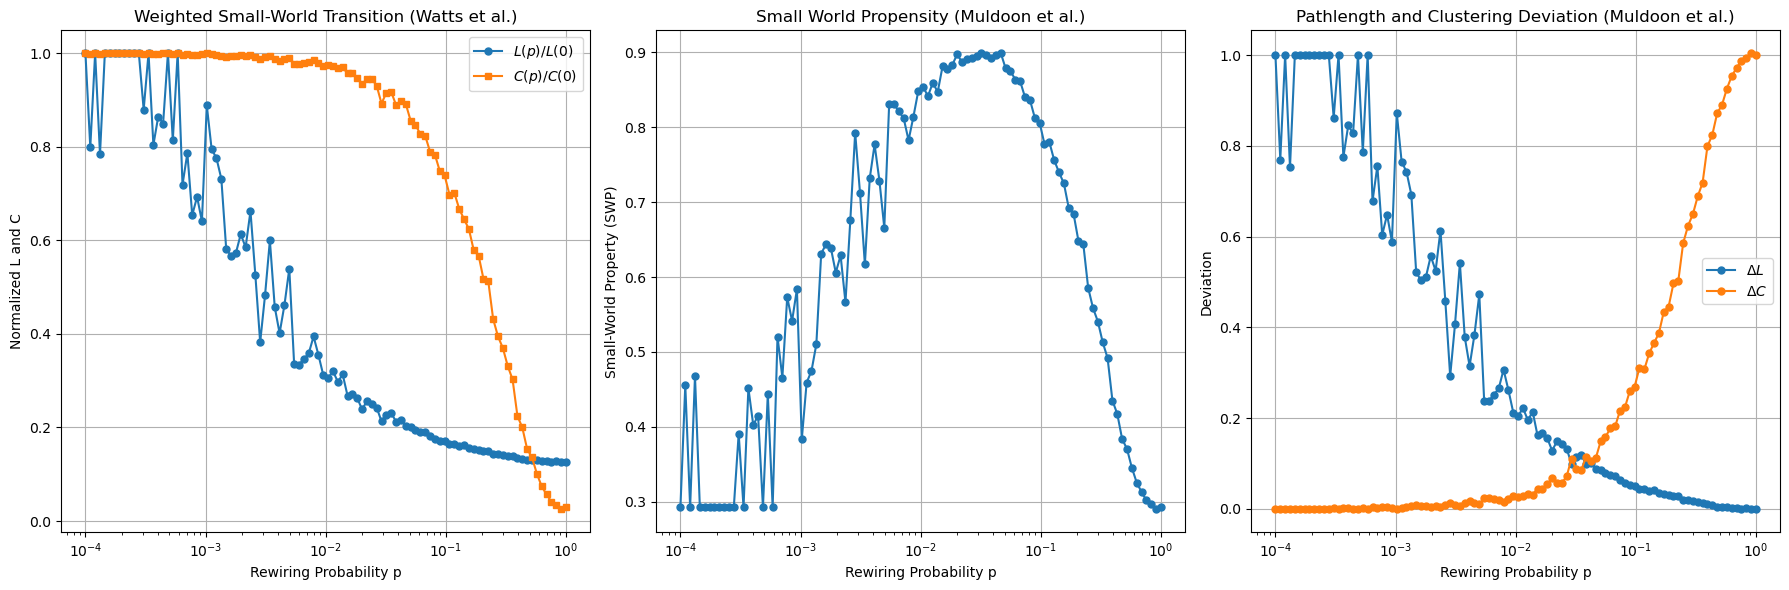

In [102]:
# Create a figure with 3 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Normalized L and C
ax[0].plot(p_values, L_values, 'o-', label=r'$L(p) / L(0)$', markersize=5)
ax[0].plot(p_values, C_values, 's-', label=r'$C(p) / C(0)$', markersize=5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Rewiring Probability p')
ax[0].set_ylabel('Normalized L and C')
ax[0].set_title("Weighted Small-World Transition (Watts et al.)")
ax[0].legend()
ax[0].grid()

# Second subplot: Small-World Property (SWP)
ax[1].plot(p_values, SWP_list, 'o-', markersize=5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Rewiring Probability p')
ax[1].set_ylabel('Small-World Property (SWP)')
ax[1].set_title('Small World Propensity (Muldoon et al.)')
ax[1].grid()

# Third subplot: Deviation in C and L
ax[2].plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)
ax[2].plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
ax[2].set_xscale('log')
ax[2].set_xlabel('Rewiring Probability p')
ax[2].set_ylabel('Deviation')
ax[2].set_title('Pathlength and Clustering Deviation (Muldoon et al.)')
ax[2].legend()
ax[2].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()


# Explore small world propensity for high order networks

Import libraries

In [58]:
import numpy as np
import xgi
import collections
import matplotlib.pyplot as plt

Define functions

In [59]:
def quad_clustering(hypergraph):
    """Compute the quad clustering coefficient for a weighted hypergraph."""
    
    # Extract unique vertices and assign indices
    vertices = sorted(set(v for edge in hypergraph for v in edge))
    vertex_index = {v: i for i, v in enumerate(vertices)}

    # Extract hyperedges
    hyperedges = list(hypergraph.keys())

    # Create an incidence matrix
    inci_mat = np.zeros((len(vertices), len(hyperedges)))

    # Fill the incidence matrix
    for j, edge in enumerate(hyperedges):
        weight = hypergraph[edge]
        for v in edge:
            inci_mat[vertex_index[v], j] = weight

    n_vertices = len(vertices)
    clu_coeff = np.zeros(n_vertices)

    # Compute weighted quad clustering coefficient
    for i in range(n_vertices):
        edge_weights = inci_mat[i, :]
        edge_indices = np.nonzero(edge_weights)[0]  # Get indices of hyperedges containing vertex i

        num_edges = len(edge_indices)
        if num_edges < 2:
            continue

        numerator = 0
        denominator = 0

        for a in range(num_edges - 1):
            edge_a = edge_indices[a]
            nodes_a = np.where(inci_mat[:, edge_a] > 0)[0]
            weights_a = inci_mat[nodes_a, edge_a]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, num_edges):
                edge_b = edge_indices[b]
                nodes_b = np.where(inci_mat[:, edge_b] > 0)[0]
                weights_b = inci_mat[nodes_b, edge_b]

                if len(nodes_b) == 1:
                    continue

                # Use min(weight sum - 1) for denominator calculation
                denominator += min(np.sum(weights_a) - 1, np.sum(weights_b) - 1)

                # Find common nodes
                common_nodes = np.intersect1d(nodes_a, nodes_b, assume_unique=True)
                if len(common_nodes) > 1:
                    numerator += np.sum(inci_mat[common_nodes, edge_a] * inci_mat[common_nodes, edge_b])

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return np.mean(clu_coeff)

def hypergraph_shortest_path_length(hypergraph):
    """Compute the average shortest path length using a higher-order hypergraph BFS method."""
    node_to_edges, edge_to_nodes = build_incidence_structure(hypergraph)
    nodes = list(node_to_edges.keys())
    
    total_distance = 0
    path_counts = 0

    for start_node in nodes[:min(100, len(nodes))]:  # Sample up to 100 nodes
        queue = collections.deque([(start_node, 0)])  # (current node, distance)
        visited_nodes = {start_node}
        visited_edges = set()

        while queue:
            node, distance = queue.popleft()
            
            for hyperedge in node_to_edges[node]:  # Get hyperedges containing this node
                if hyperedge in visited_edges:
                    continue
                visited_edges.add(hyperedge)  # Mark the hyperedge as visited
                
                for neighbor in edge_to_nodes[hyperedge]:  # Get all nodes in the hyperedge
                    if neighbor not in visited_nodes:
                        visited_nodes.add(neighbor)
                        queue.append((neighbor, distance + 1))
                        total_distance += distance + 1
                        path_counts += 1

    return total_distance / path_counts if path_counts > 0 else np.nan  # Avoid division by zero

def build_incidence_structure(hypergraph):
    """Convert the dictionary-based hypergraph into a node-to-hyperedge and hyperedge-to-node mapping."""
    node_to_edges = collections.defaultdict(set)
    edge_to_nodes = {}

    for i, (edge, _) in enumerate(hypergraph.items()):  # Ignore the weights
        edge_to_nodes[i] = set(edge)  # Map edge index to nodes
        for node in edge:
            node_to_edges[node].add(i)  # Map node to its incident edges

    return node_to_edges, edge_to_nodes

Generate lattice to increasingly random hypergraphs and compute high order pathlength, clustering and small world propensity

1. Randomly rewire accumulatively. (Note: this is note the original method, but greater randomization seems to smoothen the graph, is this better?)

In [60]:
# Define parameters
n = 500  # Number of nodes
d = 3   # Number of edges
k = 10   # Each edge connects k nodes
l = 2   # Each node belongs to l edges
p_values = np.logspace(-4, 0, 100) # Rescaling probability
clustering_list = []
shortest_pathlength_list = []

# Generate a random hypergraph
hypergraph = xgi.ring_lattice(n, d, k, l)
hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}
C0 = quad_clustering(hypergraph_dict)
L0 = hypergraph_shortest_path_length(hypergraph_dict)

for p in p_values:
    # Randomize the Watts Strogatz Hypergraph
    hypergraph = xgi.shuffle_hyperedges(hypergraph, order=2, p=p)

    # Convert the hypergraph to a dictionary format
    hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

    # Compute the hypergraph clustering and pathlength
    average_high_order_clustering = quad_clustering(hypergraph_dict)
    shortest_pathlength = hypergraph_shortest_path_length(hypergraph_dict)

    # Add to clustering and pathlength list
    clustering_list.append(average_high_order_clustering/C0)
    shortest_pathlength_list.append(shortest_pathlength/L0)

2. Rewire the initial lattice structure everytime (Note: this case is the original plot from the pairwise papers)

In [103]:
# Define parameters
n = 500  # Number of nodes
d = 3   # Number of edges
k = 10   # Each edge connects k nodes
l = 2   # Each node belongs to l edges
p_values = np.logspace(-4, 0, 100) # Rescaling probability
clustering_list = []
shortest_pathlength_list = []

# Generate a random hypergraph
hypergraph0 = xgi.ring_lattice(n, d, k, l)
hypergraph0_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph0.edges.members()}
C0 = quad_clustering(hypergraph0_dict)
L0 = hypergraph_shortest_path_length(hypergraph0_dict)

for p in p_values:
    # Randomize the Watts Strogatz Hypergraph
    hypergraph = xgi.shuffle_hyperedges(hypergraph0, order=2, p=p)

    # Convert the hypergraph to a dictionary format
    hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

    # Compute the hypergraph clustering and pathlength
    average_high_order_clustering = quad_clustering(hypergraph_dict)
    shortest_pathlength = hypergraph_shortest_path_length(hypergraph_dict)

    # Add to clustering and pathlength list
    clustering_list.append(average_high_order_clustering/C0)
    shortest_pathlength_list.append(shortest_pathlength/L0)

Calculate Small World Propensity corresponding to the rewiring probabilities

In [104]:
# Set clustering and pathlength data
C_values = clustering_list
L_values = shortest_pathlength_list

# Compute Small-World Property (SWP) efficiently using NumPy
C_observed = np.array(C_values)
L_observed = np.array(L_values)

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)

Plot high order small world analysis

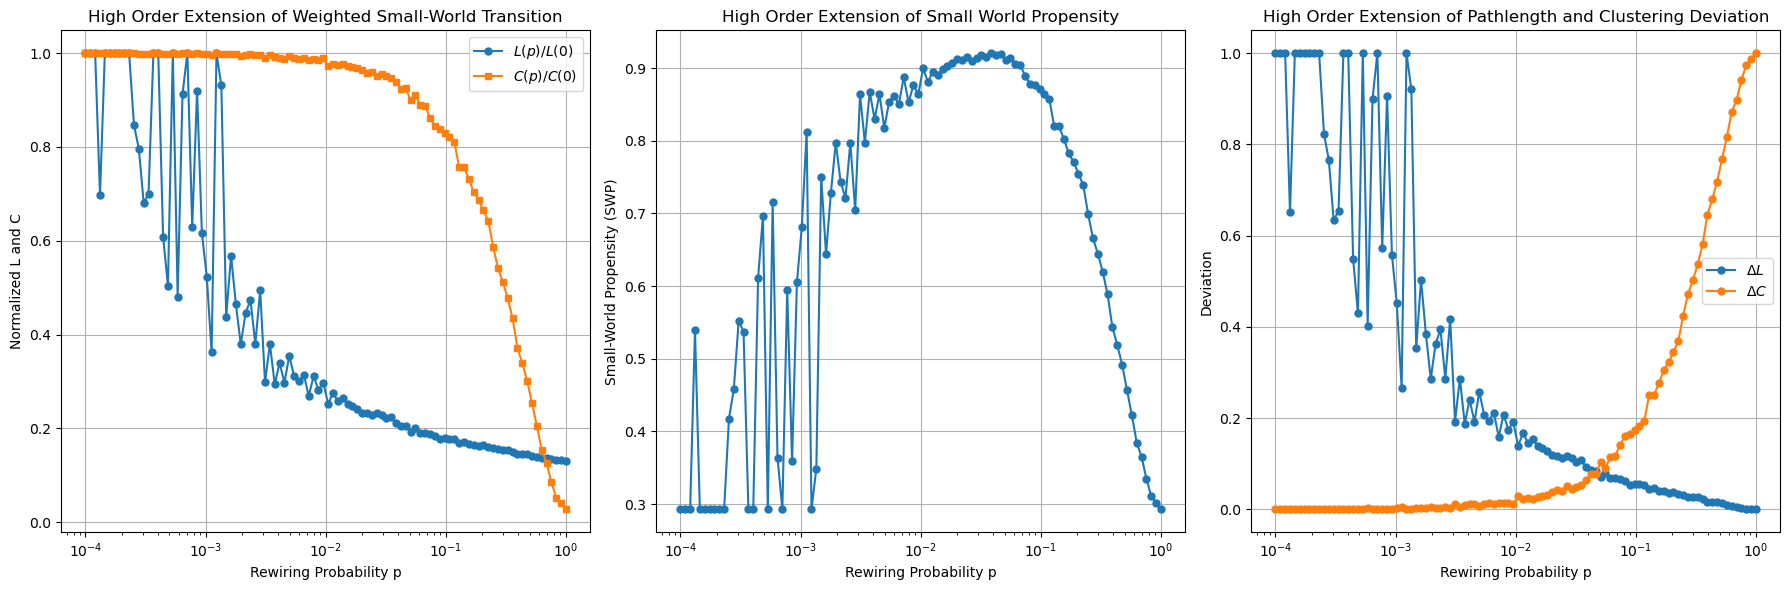

In [105]:
# Create a single figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# First plot
axes[0].plot(p_values, shortest_pathlength_list, 'o-', label=r'$L(p) / L(0)$', markersize=5)
axes[0].plot(p_values, clustering_list, 's-', label=r'$C(p) / C(0)$', markersize=5)
axes[0].set_xscale('log')
axes[0].set_xlabel('Rewiring Probability p')
axes[0].set_ylabel('Normalized L and C')
axes[0].set_title("High Order Extension of Weighted Small-World Transition")
axes[0].legend()
axes[0].grid()

# Second plot
axes[1].plot(p_values, SWP_list, 'o-', markersize=5)
axes[1].set_xscale('log')
axes[1].set_xlabel('Rewiring Probability p')
axes[1].set_ylabel('Small-World Propensity (SWP)')
axes[1].set_title('High Order Extension of Small World Propensity')
axes[1].grid()

# Third plot
axes[2].plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)
axes[2].plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
axes[2].set_xscale('log')
axes[2].set_xlabel('Rewiring Probability p')
axes[2].set_ylabel('Deviation')
axes[2].set_title('High Order Extension of Pathlength and Clustering Deviation')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Explore high order small world propensity for pairwise networks

Import libraries

In [ ]:
import numpy as np
import xgi
import collections
import matplotlib.pyplot as plt

Define functions

In [73]:
def quad_clustering(hypergraph):
    """Compute the quad clustering coefficient for a weighted hypergraph."""
    
    # Extract unique vertices and assign indices
    vertices = sorted(set(v for edge in hypergraph for v in edge))
    vertex_index = {v: i for i, v in enumerate(vertices)}

    # Extract hyperedges
    hyperedges = list(hypergraph.keys())

    # Create an incidence matrix
    inci_mat = np.zeros((len(vertices), len(hyperedges)))

    # Fill the incidence matrix
    for j, edge in enumerate(hyperedges):
        weight = hypergraph[edge]
        for v in edge:
            inci_mat[vertex_index[v], j] = weight

    n_vertices = len(vertices)
    clu_coeff = np.zeros(n_vertices)

    # Compute weighted quad clustering coefficient
    for i in range(n_vertices):
        edge_weights = inci_mat[i, :]
        edge_indices = np.nonzero(edge_weights)[0]  # Get indices of hyperedges containing vertex i

        num_edges = len(edge_indices)
        if num_edges < 2:
            continue

        numerator = 0
        denominator = 0

        for a in range(num_edges - 1):
            edge_a = edge_indices[a]
            nodes_a = np.where(inci_mat[:, edge_a] > 0)[0]
            weights_a = inci_mat[nodes_a, edge_a]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, num_edges):
                edge_b = edge_indices[b]
                nodes_b = np.where(inci_mat[:, edge_b] > 0)[0]
                weights_b = inci_mat[nodes_b, edge_b]

                if len(nodes_b) == 1:
                    continue

                # Use min(weight sum - 1) for denominator calculation
                denominator += min(np.sum(weights_a) - 1, np.sum(weights_b) - 1)

                # Find common nodes
                common_nodes = np.intersect1d(nodes_a, nodes_b, assume_unique=True)
                if len(common_nodes) > 1:
                    numerator += np.sum(inci_mat[common_nodes, edge_a] * inci_mat[common_nodes, edge_b])

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return np.mean(clu_coeff)

def hypergraph_shortest_path_length(hypergraph):
    """Compute the average shortest path length using a higher-order hypergraph BFS method."""
    node_to_edges, edge_to_nodes = build_incidence_structure(hypergraph)
    nodes = list(node_to_edges.keys())
    
    total_distance = 0
    path_counts = 0

    for start_node in nodes[:min(100, len(nodes))]:  # Sample up to 100 nodes
        queue = collections.deque([(start_node, 0)])  # (current node, distance)
        visited_nodes = {start_node}
        visited_edges = set()

        while queue:
            node, distance = queue.popleft()
            
            for hyperedge in node_to_edges[node]:  # Get hyperedges containing this node
                if hyperedge in visited_edges:
                    continue
                visited_edges.add(hyperedge)  # Mark the hyperedge as visited
                
                for neighbor in edge_to_nodes[hyperedge]:  # Get all nodes in the hyperedge
                    if neighbor not in visited_nodes:
                        visited_nodes.add(neighbor)
                        queue.append((neighbor, distance + 1))
                        total_distance += distance + 1
                        path_counts += 1

    return total_distance / path_counts if path_counts > 0 else np.nan  # Avoid division by zero

def build_incidence_structure(hypergraph):
    """Convert the dictionary-based hypergraph into a node-to-hyperedge and hyperedge-to-node mapping."""
    node_to_edges = collections.defaultdict(set)
    edge_to_nodes = {}

    for i, (edge, _) in enumerate(hypergraph.items()):  # Ignore the weights
        edge_to_nodes[i] = set(edge)  # Map edge index to nodes
        for node in edge:
            node_to_edges[node].add(i)  # Map node to its incident edges

    return node_to_edges, edge_to_nodes

def graph_to_dictionary(G):
    # Extract nodes
    nodes = { (node,): len(G0[node]) for node in G0.nodes() }

    # Extract edges with weights
    edges = { tuple(sorted(edge)): 2 for edge in G0.edges() }

    # Merge into final dictionary format
    network = {**nodes, **edges}
    return network

Generate lattice to increasingly random graphs and compute high order pathlength, clustering and small world propensity

In [76]:
# Define parameters
n = 500  # Number of nodes
k = 10    # Each node is connected to k/2 neighbors on both sides
p_values = np.logspace(-4, 0, 100) # Rescaling probability
clustering_list = []
shortest_pathlength_list = []

# Generate a random hypergraph
graph = ring_lattice(n, k)
graph_dict = graph_to_dictionary(graph)
C0 = quad_clustering(graph_dict)
L0 = hypergraph_shortest_path_length(graph_dict)

for p in p_values:
    # Randomize the Watts Strogatz Hypergraph
    G = rewire_graph(graph, p)

    # Convert the hypergraph to a dictionary format
    graph_dict = graph_to_dictionary(graph)

    # Compute the hypergraph clustering and pathlength
    average_high_order_clustering = quad_clustering(graph_dict)
    shortest_pathlength = hypergraph_shortest_path_length(graph_dict)

    # Add to clustering and pathlength list
    clustering_list.append(average_high_order_clustering/C0)
    shortest_pathlength_list.append(shortest_pathlength/L0)

C:\Users\cyril\AppData\Local\Temp\ipykernel_24560\151387700.py:26: RuntimeWarning: invalid value encountered in scalar divide
  clustering_list.append(average_high_order_clustering/C0)


Calculate Small World Propensity corresponding to the rewiring probabilities

In [77]:
# Set clustering and pathlength data
C_values = clustering_list
L_values = shortest_pathlength_list

# Compute Small-World Property (SWP) efficiently using NumPy
C_observed = np.array(C_values)
L_observed = np.array(L_values)

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)

C:\Users\cyril\AppData\Local\Temp\ipykernel_24560\910073601.py:16: RuntimeWarning: invalid value encountered in divide
  dL = (L_observed - L_random) / (L0 - L_random)


Plot high order small world analysis

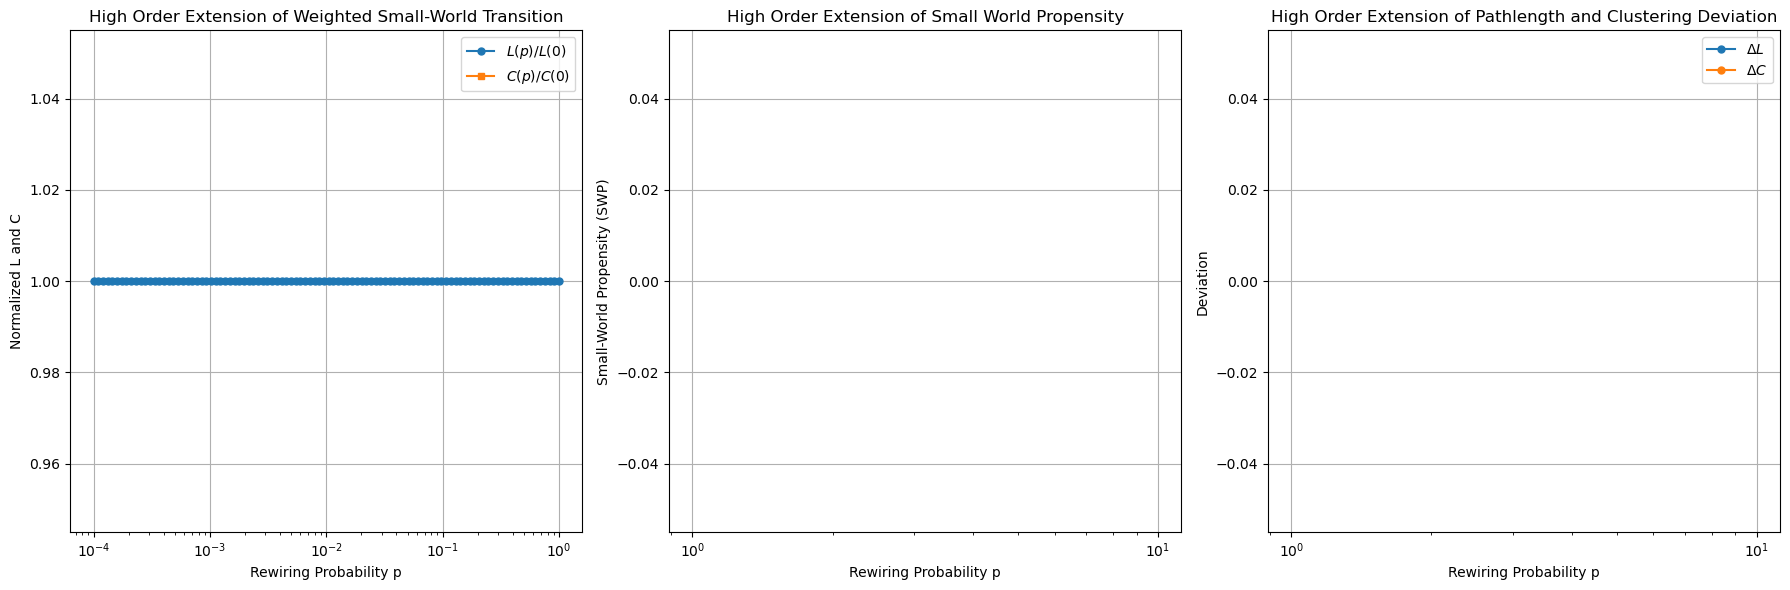

In [79]:
# Create a single figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# First plot
axes[0].plot(p_values, shortest_pathlength_list, 'o-', label=r'$L(p) / L(0)$', markersize=5)
axes[0].plot(p_values, clustering_list, 's-', label=r'$C(p) / C(0)$', markersize=5)
axes[0].set_xscale('log')
axes[0].set_xlabel('Rewiring Probability p')
axes[0].set_ylabel('Normalized L and C')
axes[0].set_title("High Order Extension of Weighted Small-World Transition")
axes[0].legend()
axes[0].grid()

# Second plot
axes[1].plot(p_values, SWP_list, 'o-', markersize=5)
axes[1].set_xscale('log')
axes[1].set_xlabel('Rewiring Probability p')
axes[1].set_ylabel('Small-World Propensity (SWP)')
axes[1].set_title('High Order Extension of Small World Propensity')
axes[1].grid()

# Third plot
axes[2].plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)
axes[2].plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
axes[2].set_xscale('log')
axes[2].set_xlabel('Rewiring Probability p')
axes[2].set_ylabel('Deviation')
axes[2].set_title('High Order Extension of Pathlength and Clustering Deviation')
axes[2].legend()
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Explore pairwise small world propensity for high order networks

Import libraries

In [106]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Define functions

In [113]:
def ring_lattice(n, k):
    """ Create a weighted ring lattice where each node is connected to k/2 neighbors on each side. """
    G = nx.Graph()
    for i in range(n):
        for j in range(1, k // 2 + 1):  
            weight1 = np.random.uniform(0.5, 1.5)  # Assign random weights
            weight2 = np.random.uniform(0.5, 1.5)
            G.add_edge(i, (i + j) % n, weight=weight1)
            G.add_edge(i, (i - j) % n, weight=weight2)
    return G

def rewire_graph(G, p):
    """ Rewire edges with probability p while maintaining weights. """
    new_G = G.copy()
    edges = list(G.edges(data=True))  # Extract edges with weights
    nodes = list(G.nodes())

    for u, v, data in edges:
        if np.random.rand() < p:
            new_G.remove_edge(u, v)  # Remove the original edge
            
            while True:
                new_v = np.random.choice(nodes)
                if new_v != u and not new_G.has_edge(u, new_v):
                    new_weight = np.random.uniform(0.5, 1.5)  # Assign new random weight
                    new_G.add_edge(u, new_v, weight=new_weight)
                    break
    return new_G

def random_graph(n, k):
    """ Create a weighted random graph with the same number of nodes and edges. """
    G = nx.gnm_random_graph(n, (n * k) // 2)
    
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.5, 1.5)  # Assign weights
    return G

def compute_L_C(G):
    """ Compute weighted characteristic path length (L) and weighted clustering coefficient (C). """
    # Weighted clustering coefficient using Onnela et al. method (as per Muldoon et al. paper)
    C = np.mean(list(nx.clustering(G, weight="weight").values()))
    
    # Weighted characteristic path length (using Dijkstra's algorithm)
    try:
        L = nx.average_shortest_path_length(G, weight="weight")
    except nx.NetworkXError:
        L = np.nan  # If graph is disconnected, return NaN
    return L, C

def hypergraph_to_graph(hypergraph):
    """
    Converts an XGI hypergraph to a standard NetworkX graph using clique expansion.
    
    Args:
    hypergraph (xgi.Hypergraph): A Hypergraph object from the XGI library.
    
    Returns:
    nx.Graph: A NetworkX graph where hyperedges are converted to cliques.
    """
    G = nx.Graph()
    
    for nodes in hypergraph.edges.members():
        node_list = list(nodes)
        # Add all nodes from the hyperedge
        G.add_nodes_from(node_list)
        # Form a clique (connect all pairs)
        for i in range(len(node_list)):
            for j in range(i + 1, len(node_list)):
                G.add_edge(node_list[i], node_list[j])
    
    return G


Generate high order graphs and compute pairwise metrics

In [125]:
# Define parameters
n = 500  # Number of nodes
d = 3   # Number of edges
k = 10   # Each edge connects k nodes
l = 2   # Each node belongs to l edges
p_values = np.logspace(-4, 0, 100) # Rescaling probability
L_values = []
C_values = []

# Generate a random hypergraph
hypergraph0 = xgi.ring_lattice(n, d, k, l)
graph0 = hypergraph_to_graph(hypergraph0)
L0, C0 = compute_L_C(G0)

for p in p_values:
    # Randomize the Watts Strogatz Hypergraph
    hypergraph = xgi.shuffle_hyperedges(hypergraph0, order=2, p=p)
    graph = hypergraph_to_graph(hypergraph)
    L, C = compute_L_C(graph)
    L_values.append(L / L0)  # Normalized weighted path length
    C_values.append(C / C0)

In [126]:
# Compute Small-World Property (SWP) efficiently using NumPy
C_observed = np.array(C_values)
L_observed = np.array(L_values)

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

# Calculate deviations
dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

# Calculate Small World Propensity
SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)

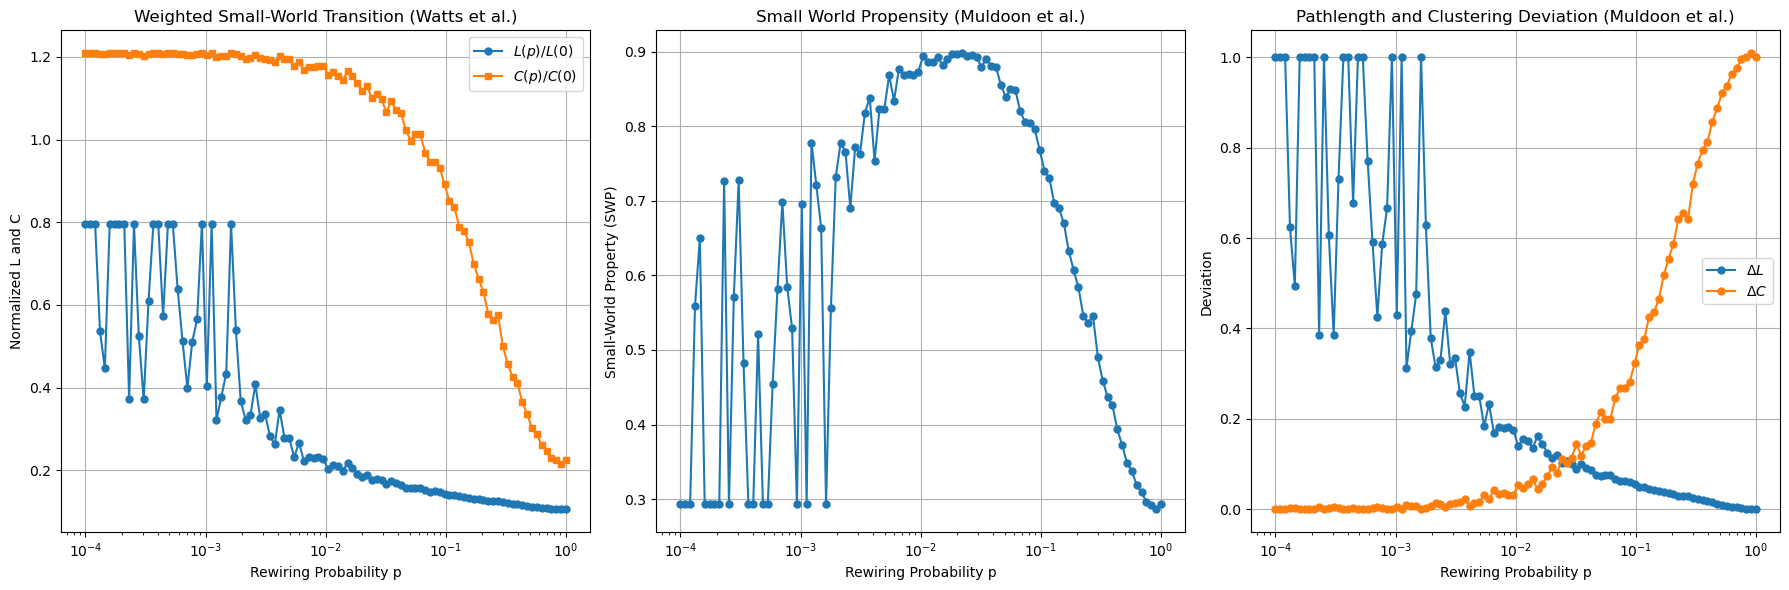

In [127]:
# Create a figure with 3 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Normalized L and C
ax[0].plot(p_values, L_values, 'o-', label=r'$L(p) / L(0)$', markersize=5)
ax[0].plot(p_values, C_values, 's-', label=r'$C(p) / C(0)$', markersize=5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Rewiring Probability p')
ax[0].set_ylabel('Normalized L and C')
ax[0].set_title("Weighted Small-World Transition (Watts et al.)")
ax[0].legend()
ax[0].grid()

# Second subplot: Small-World Property (SWP)
ax[1].plot(p_values, SWP_list, 'o-', markersize=5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Rewiring Probability p')
ax[1].set_ylabel('Small-World Property (SWP)')
ax[1].set_title('Small World Propensity (Muldoon et al.)')
ax[1].grid()

# Third subplot: Deviation in C and L
ax[2].plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)
ax[2].plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
ax[2].set_xscale('log')
ax[2].set_xlabel('Rewiring Probability p')
ax[2].set_ylabel('Deviation')
ax[2].set_title('Pathlength and Clustering Deviation (Muldoon et al.)')
ax[2].legend()
ax[2].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Compare high order to pairwise metrics

In [136]:
# Define parameters
n = 500  # Number of nodes
d = 3   # Number of edges
k = 10   # Each edge connects k nodes
l = 2   # Each node belongs to l edges
p_values = np.logspace(-4, 0, 100) # Rescaling probability
L_values = []
C_values = []
L_values_HOI = []
C_values_HOI = []

# Generate a random hypergraph
hypergraph0 = xgi.ring_lattice(n, d, k, l)

# Compute pairwise metrics
graph0 = hypergraph_to_graph(hypergraph0)
L0, C0 = compute_L_C(graph0)

# Compute high order metrics
hypergraph0_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph0.edges.members()}
C0_HOI = quad_clustering(hypergraph0_dict)
L0_HOI = hypergraph_shortest_path_length(hypergraph0_dict)

# Randomize the lattice hypergraph
for p in p_values:
    hypergraph = xgi.shuffle_hyperedges(hypergraph0, order=2, p=p)

    # Compute pairwise metrics
    graph = hypergraph_to_graph(hypergraph)
    L, C = compute_L_C(graph)
    L_values.append(L / L0)  # Normalized weighted path length
    C_values.append(C / C0)

    # Compute high order metrics
    hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}
    L_HOI = hypergraph_shortest_path_length(hypergraph_dict)
    C_HOI = quad_clustering(hypergraph_dict)
    L_values_HOI.append(L_HOI/L0_HOI)
    C_values_HOI.append(C_HOI/C0_HOI)

In [137]:
# Compute Small-World Property (SWP) for pairwise metrics
C_observed = np.array(C_values)
L_observed = np.array(L_values)

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

# Calculate deviations
dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

# Calculate Small World Propensity
SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)




# Compute Small-World Property (SWP) for high order metrics
C_observed_HOI = np.array(C_values_HOI)
L_observed_HOI = np.array(L_values_HOI)

# Set extreme values
C0_HOI = C_observed[0]
C_random_HOI = C_observed_HOI[-1]
L0_HOI = L_observed_HOI[0]
L_random_HOI = L_observed_HOI[-1]

# Calculate deviations
dC_HOI = (C0_HOI - C_observed_HOI) / (C0_HOI - C_random_HOI)
dL_HOI = (L_observed_HOI - L_random_HOI) / (L0_HOI - L_random_HOI)

# Calculate Small World Propensity
SWP_list_HOI = 1 - np.sqrt((dC_HOI**2 + dL_HOI**2) / 2)

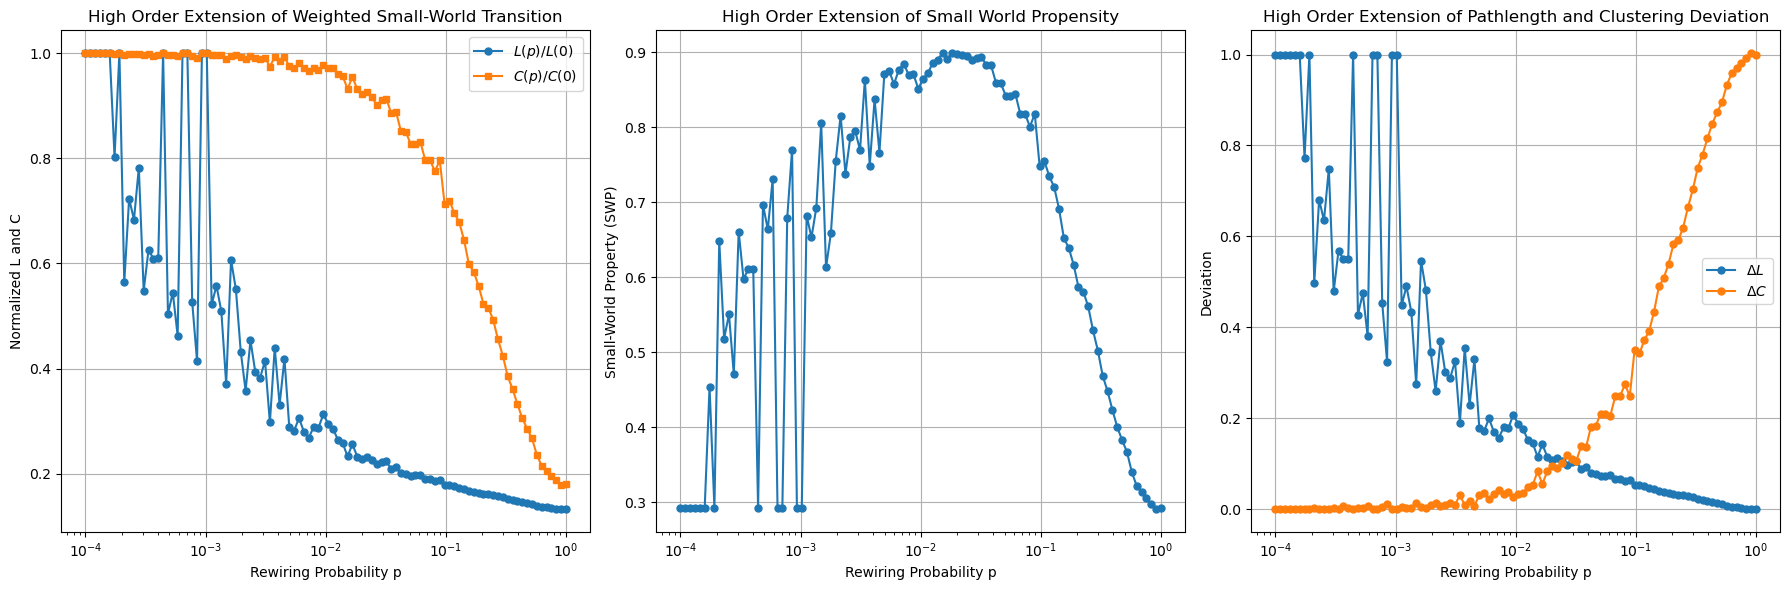

In [141]:
# Create a figure with 3 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Normalized L and C
ax[0].plot(p_values, L_values, 'o-', label=r'$L(p) / L(0)$', markersize=5)
ax[0].plot(p_values, C_values, 's-', label=r'$C(p) / C(0)$', markersize=5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Rewiring Probability p')
ax[0].set_ylabel('Normalized L and C')
ax[0].set_title("High Order Extension of Weighted Small-World Transition")
ax[0].legend()
ax[0].grid()

# Second subplot: Small-World Property (SWP)
ax[1].plot(p_values, SWP_list, 'o-', markersize=5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Rewiring Probability p')
ax[1].set_ylabel('Small-World Property (SWP)')
ax[1].set_title('High Order Extension of Small World Propensity')
ax[1].grid()

# Third subplot: Deviation in C and L
ax[2].plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)
ax[2].plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
ax[2].set_xscale('log')
ax[2].set_xlabel('Rewiring Probability p')
ax[2].set_ylabel('Deviation')
ax[2].set_title('High Order Extension of Pathlength and Clustering Deviation')
ax[2].legend()
ax[2].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()

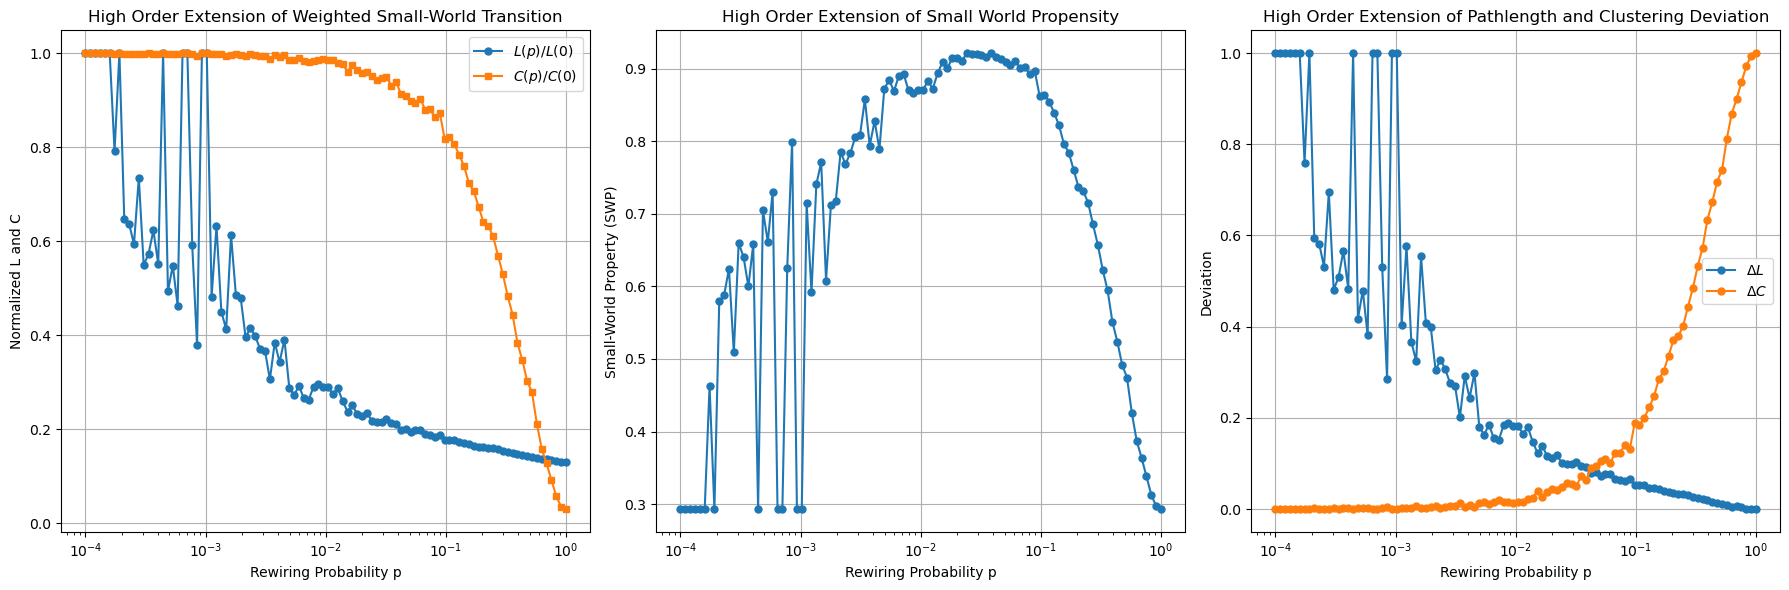

In [140]:
# Create a figure with 3 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Normalized L and C
ax[0].plot(p_values, L_values_HOI, 'o-', label=r'$L(p) / L(0)$', markersize=5)
ax[0].plot(p_values, C_values_HOI, 's-', label=r'$C(p) / C(0)$', markersize=5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Rewiring Probability p')
ax[0].set_ylabel('Normalized L and C')
ax[0].set_title("High Order Extension of Weighted Small-World Transition")
ax[0].legend()
ax[0].grid()

# Second subplot: Small-World Property (SWP)
ax[1].plot(p_values, SWP_list_HOI, 'o-', markersize=5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Rewiring Probability p')
ax[1].set_ylabel('Small-World Property (SWP)')
ax[1].set_title('High Order Extension of Small World Propensity')
ax[1].grid()

# Third subplot: Deviation in C and L
ax[2].plot(p_values, dL_HOI, 'o-', label=r'$\Delta L$', markersize=5)
ax[2].plot(p_values, dC_HOI, 'o-', label=r'$\Delta C$', markersize=5)
ax[2].set_xscale('log')
ax[2].set_xlabel('Rewiring Probability p')
ax[2].set_ylabel('Deviation')
ax[2].set_title('High Order Extension of Pathlength and Clustering Deviation')
ax[2].legend()
ax[2].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()